# Setup

In [1]:
import json
import os
import sys
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder

from verde import BlockKFold

from utils import read_csv_non_utf, preprocess_data, get_zero_nonzero_datasets, ratios_to_DI_cats

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)

## Helper functions

In [4]:
# A convenience function for plotting the cross-validation from the sklearn user guide:
#  - https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#visualizing-cross-validation-behavior-in-scikit-learn
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw = 10):
    
    """Create a sample plot for indices of a cross-validation object."""

    # Establishing color maps for plotting
    cmap_cv = plt.cm.Set1
    cmap_data = plt.cm.inferno

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X = X, y = y, groups = group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c = indices,
            marker = '_',
            lw = lw,
            cmap = cmap_cv,
            vmin = -0.2,
            vmax = 1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c = y, marker = '_', lw = lw, cmap = cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c = group, marker = '_', lw = lw, cmap = cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(
        yticks = np.arange(n_splits + 2) + 0.5,
        yticklabels = yticklabels,
        xlabel = 'Sample index',
        ylabel = 'CV iteration',
        ylim = [n_splits + 2.2, -0.2],
    )
    ax.set_title('{}'.format(type(cv).__name__), fontsize = 15)
    return ax

# Group-based fold blocking

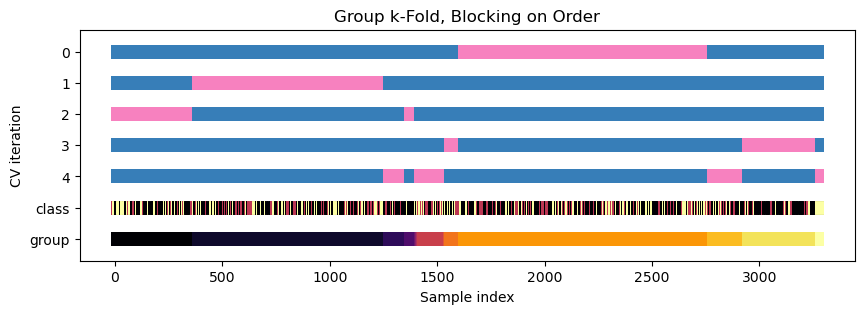

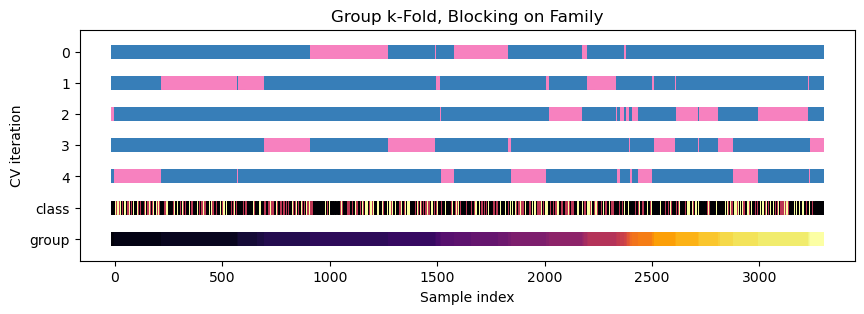

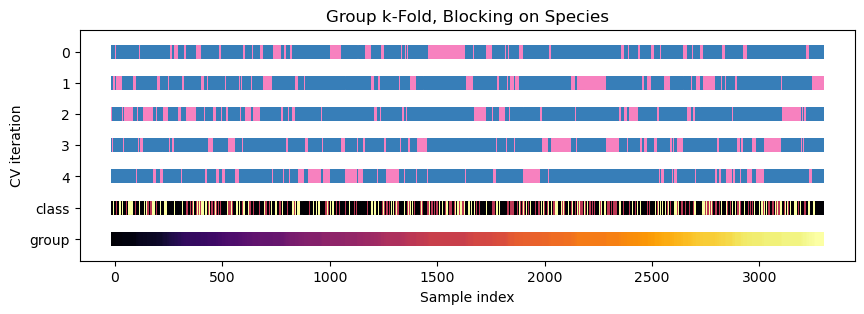

In [5]:
# Visualizing group-based cross-val behavior
group_var = ['Order', 'Family', 'Species']

for var in group_var: 
    ben_lop2019['group'] = LabelEncoder().fit_transform(ben_lop2019[var])
    ben_lop2019 = ben_lop2019.sort_values('group')
    
    X = ben_lop2019[['BM', 'DistKm', 'Reserve', 'TravTime']]
    y = ratios_to_DI_cats(ben_lop2019['ratio'])
    groups = ben_lop2019['group']
    
    n_splits = 5
    cv = GroupKFold(n_splits = n_splits)
    
    fig, ax = plt.subplots(figsize = (10, 3))
    plot_cv_indices(cv, X, y, groups, ax, n_splits)
    ax.set_title(f'Group k-Fold, Blocking on {var}');

In [6]:
# Checking overall class representation
DI_cats = ratios_to_DI_cats(ben_lop2019['ratio'])
DI_cats.value_counts() / len(DI_cats) * 100

ratio
0.0    53.825053
2.0    23.895154
1.0    22.279793
Name: count, dtype: float64

In [7]:
# Checking the class representation across block folds
for var in group_var: 
    print_text = 'BLOCKING ON ' + var.upper()
    print(print_text + '\n' + '-' * len(print_text))
    
    ben_lop2019['group'] = LabelEncoder().fit_transform(ben_lop2019[var])
    ben_lop2019 = ben_lop2019.sort_values('group')
    
    X = ben_lop2019[['BM', 'DistKm', 'Reserve', 'TravTime']].values
    y = ratios_to_DI_cats(ben_lop2019['ratio']).values
    groups = ben_lop2019['group'].values
    
    n_splits = 5
    cv = GroupKFold(n_splits = n_splits)

    group_members_seen = []
    for train_idx, test_idx in cv.split(X = X, y = y, groups = groups):
        print(f'Train size: {len(train_idx)}')
        cls, counts = np.unique(y[train_idx], return_counts = True)
        
        for c, cnt in zip(cls, counts):
            pct = (cnt / counts.sum()) * 100
            print(f'{round(pct, 1)}% for class {int(c)}')
        print('---')

        group_members_seen.extend(np.unique(groups[test_idx])) # checking which groups were in this test set

    if (len(set(group_members_seen)) == len(group_members_seen)) and (len(group_members_seen) == len(np.unique(groups))):
        print('All groups seen and only seen in one test set!')

    print()

BLOCKING ON ORDER
-----------------
Train size: 2121
54.6% for class 0
21.8% for class 1
23.6% for class 2
---
Train size: 2392
55.0% for class 0
21.5% for class 1
23.5% for class 2
---
Train size: 2857
53.0% for class 0
23.1% for class 1
23.9% for class 2
---
Train size: 2875
52.4% for class 0
22.8% for class 1
24.8% for class 2
---
Train size: 2879
54.5% for class 0
21.9% for class 1
23.5% for class 2
---
All groups seen and only seen in one test set!

BLOCKING ON FAMILY
------------------
Train size: 2624
52.7% for class 0
22.6% for class 1
24.7% for class 2
---
Train size: 2624
54.2% for class 0
21.7% for class 1
24.0% for class 2
---
Train size: 2624
52.8% for class 0
22.9% for class 1
24.4% for class 2
---
Train size: 2626
53.9% for class 0
21.8% for class 1
24.3% for class 2
---
Train size: 2626
55.5% for class 0
22.4% for class 1
22.1% for class 2
---
All groups seen and only seen in one test set!

BLOCKING ON SPECIES
-------------------
Train size: 2625
53.2% for class 0
22.7%

In [8]:
# Checking that behavior is consistent, i.e., there's no randomness involved
n_splits = 5
cv1 = GroupKFold(n_splits = n_splits)
split1 = [(train_idx, test_idx) for train_idx, test_idx in cv1.split(X = X, y = y, groups = groups)]

cv2 = GroupKFold(n_splits = n_splits)
split2 = [(train_idx, test_idx) for train_idx, test_idx in cv2.split(X = X, y = y, groups = groups)]

for i, (c1, c2) in enumerate(zip(split1, split2)):
    print(f'Split {i}')
    print('Differences in train indices:', (c1[0] != c2[0]).sum())
    print('Differences in test indices:', (c1[1] != c2[1]).sum())
    print()

Split 0
Differences in train indices: 0
Differences in test indices: 0

Split 1
Differences in train indices: 0
Differences in test indices: 0

Split 2
Differences in train indices: 0
Differences in test indices: 0

Split 3
Differences in train indices: 0
Differences in test indices: 0

Split 4
Differences in train indices: 0
Differences in test indices: 0



# Spatial fold blocking

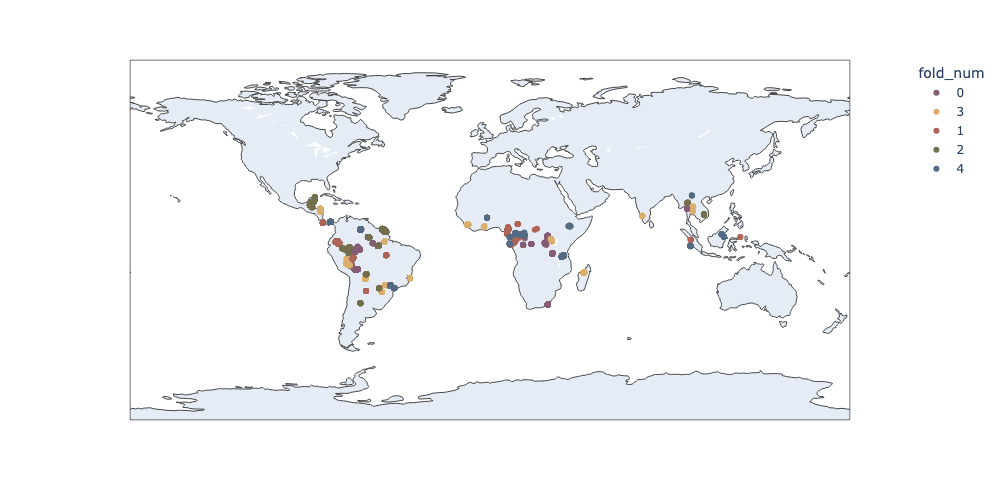

In [37]:
# Testing out verde's spatial blocking capabilities
coords = ben_lop2019[['X', 'Y']].values
bkf = BlockKFold(spacing = 5, n_splits = 5, shuffle = True, random_state = 1693)

idx_fold_num = np.zeros_like(coords[ : , 0])
for i, (train_idx, test_idx) in enumerate(bkf.split(coords)):
    idx_fold_num[test_idx] = i

ben_lop2019['fold_num'] = idx_fold_num.astype(int).astype(str)

# Plotting study locations as a scatterplot
fig = px.scatter_geo(ben_lop2019, 
                     lat = 'Y',
                     lon = 'X',
                     color = 'fold_num',
                     hover_name = 'Reference',
                     width = 1000,
                     height = 500,
                     color_discrete_sequence = px.colors.qualitative.Antique)
fig.show()

# Sketching out a function to run cross-validation

In [4]:
from sklearn.base import clone
from sklearn.metrics import balanced_accuracy_score, recall_score, mean_absolute_error
from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegression, LogisticRegressionCV

from pymer4 import Lmer
from flaml import AutoML

from utils import direct_train_test
from model_utils import HurdleModelEstimator, PymerModelWrapper
from custom_metrics import balanced_accuracy_FLAML

In [5]:
# Checking out how to safely clone an sklearn model
hm = HurdleModelEstimator(zero_model = LogisticRegression(C = 10.0), nonzero_model = ElasticNet())

#  checking memory sameness: fit one model but not the other...
pp_data = preprocess_data(ben_lop2019, include_indicators = False, standardize = True, log_trans_cont = False,
                          polynomial_features = 0)
hm.fit(pp_data)

hm_clone = clone(hm)
print('Same hurdle models in memory?', hm is hm_clone)
print('Same zero model in memory?', hm.zero_model is hm_clone.zero_model)
print('Same nonzero model in memory?', hm.nonzero_model is hm_clone.nonzero_model)
print()

try:
    hm.zero_model.coef_
    print('Original has fitted coefficients')
except AttributeError:
    print('Original DOESN\'T have fitted coefficients')

try:
    hm_clone.zero_model.coef_
    print('Copy has fitted coefficients')
except AttributeError:
    print('Copy DOESN\'T have fitted coefficients')

Same hurdle models in memory? False
Same zero model in memory? False
Same nonzero model in memory? False

Original has fitted coefficients
Copy DOESN'T have fitted coefficients


In [6]:
def run_cross_val(model, data, block_type = None, num_folds = 5, group_col = None, spatial_spacing = 5,
                  fit_args = None, pp_args = None, class_metrics = None, reg_metrics = None, verbose = True, 
                  random_state = 1693, sklearn_submodels = False, back_transform = True, direct = None):

    """
    A function to run k-fold cross-validation over a given dataset and with a given model. Multiple
    types of blocking are supported, including spatial- and group-blocking of folds. Multiple model types
    are supported as well, i.e., two-stage hurdle and direct regression/classification models.

    Parameters
    ----------
    model : sklearn-like
    data : pandas.DataFrame
    block_type : string
    num_folds : integer
    group_col : string
    spatial_spacing : integer
    fit_args : dictionary
    pp_args : dictionary
    class_metrics : dictionary
    reg_metrics : dictionary
    verbose : boolean
    random_state : integer
    sklearn_submodels : boolean
    back_transform : boolean
    direct : string

    Returns
    -------
    metric_dict : dictionary
    """

    # Setting mutable defaults
    assert (class_metrics is not None) or (reg_metrics is not None), 'Please provide at least one classification or regression metric.'

    if class_metrics is None:
        class_metrics = []
    if reg_metrics is None:
        reg_metrics = []
    if fit_args is None:
        fit_args = {}
    if pp_args is None:
        pp_args = {}

    # Establishing k-fold parameters
    if block_type is None:
        if verbose:
            print('Using standard cross-validation')
        groups = None
        kfold = KFold(n_splits = num_folds, random_state = random_state, shuffle = True)
    elif block_type == 'group':
        assert group_col is not None, 'If using group-based blocking, a group column must be specified using "group_col."'
        
        if verbose:
            print(f'Using group blocking on column {group_col}')
        groups = data[group_col].values
        kfold = GroupKFold(n_splits = num_folds)
    elif block_type == 'spatial':
        if verbose:
            print(f'Using spatial blocking on with spacing {spatial_spacing} degrees')
        groups = None
        kfold = BlockKFold(spacing = spatial_spacing, n_splits = num_folds, shuffle = True, random_state = random_state)
    
    # Data structures for saving results
    classes = {0 : 'low', 1 : 'medium', 2 : 'high'}
    metric_dict = {}

    for m in class_metrics['per_class']:
        metric_dict[m] = {classes[c] : [] for c in classes}
    for m in class_metrics['overall']:
        metric_dict[m] = []
    for m in reg_metrics:
        metric_dict[m] = []

    # Running the k-fold cross-validation
    coords = data[['X', 'Y']].values
    for i, (train_idx, test_idx) in enumerate(kfold.split(coords, groups = groups)):
        if verbose:
            print(f'Fold {i}:')
        
        train_test_idxs = {'train' : train_idx, 'test' : test_idx}
        pp_data = preprocess_data(data, standardize = True, train_test_idxs = train_test_idxs, **pp_args)

        # Fitting/predicting differently for direct classification/regression vs. hurdle models
        if direct is None:
            train_data, test_data = pp_data.iloc[train_idx].copy(deep = True), pp_data.iloc[test_idx].copy(deep = True)

            #  clone the model to ensure it fits from scratch... Pymer submodels do this through the wrapper class
            #   at fit time and AutoML instances do this when "keep_search_state" is False
            if sklearn_submodels:
                model = clone(model)

            #  train the model
            with warnings.catch_warnings(action = 'ignore'):
                if verbose:
                    print('  training model')
                model.fit(train_data, fit_args)

            #  predicting on the test set
            y_pred = model.predict(test_data)
            y_test = test_data['ratio'].copy(deep = True)

            #  back-transforming to go from RRs --> ratios
            if back_transform:
                y_pred[y_pred != 0] = np.exp(y_pred[y_pred != 0])
        else: 
            assert direct in ['classification', 'regression'], 'The "direct" argument must either be "classification" or "regression."'

            #  getting the data split
            X_train, y_train, X_test, y_test = direct_train_test(pp_data, task = direct, already_pp = True, 
                                                                 train_test_idxs = train_test_idxs)

            #  training the model + perform model search
            automl.fit(X_train = X_train, y_train = y_train, **fit_args)

            #  predicting on the test set
            y_pred = automl.predict(X_test)
            
        # Get predictions and targets
        if verbose:
            print('  getting test metrics') 

        # Discretize ratios for regression models to get classification metrics
        #  - case where our predictions are in the form of DI categories
        if direct == 'classification':
            true_DI_cats = y_test
            pred_DI_cats = y_pred
        #  - case where our predictions are in the form of ratios
        elif len(class_metrics) != 0:
            true_DI_cats = ratios_to_DI_cats(y_test)
            pred_DI_cats = ratios_to_DI_cats(y_pred)

        # Get TEST metrics for this train/test split
        for metric in reg_metrics.keys():
            kws = reg_metrics[metric]['kwargs']
            metric_dict[metric].append(reg_metrics[metric]['function'](y_test, y_pred, **kws))

        for c in classes:
            #  binarizing the true/pred labels
            true = (true_DI_cats == c).astype(int)
            pred = (pred_DI_cats == c).astype(int)

            for metric in class_metrics['per_class'].keys():
                kws = class_metrics['per_class'][metric]['kwargs']
                metric_dict[metric][classes[c]].append(class_metrics['per_class'][metric]['function'](true, pred, **kws))

        for metric in class_metrics['overall'].keys():
            kws = class_metrics['overall'][metric]['kwargs']
            metric_dict[metric].append(class_metrics['overall'][metric]['function'](true, pred, **kws))
    
    return metric_dict

In [7]:
# Defining the metrics to use
class_metrics = {'per_class' : {'balanced_accuracy' : {'function' : balanced_accuracy_score,
                                                       'kwargs' : {}
                                                      },
                                'sensitivity' : {'function' : recall_score,
                                                 'kwargs' : {'pos_label' : 1}
                                                 },
                                'specificity' : {'function' : recall_score,
                                                 'kwargs' : {'pos_label' : 0}
                                                 }
                               },
                  'overall' : {'balanced_accuracy_overall' : {'function' : balanced_accuracy_score,
                                                              'kwargs' : {}
                                                             }
                              }
                }
reg_metrics = {'mean_absolute_error' : {'function' : mean_absolute_error,
                                        'kwargs' : {}
                                       }
              }

# Choosing the model to use, among pymer, sklearn, and FLAML
model_to_use = 'FLAML_hurdle'

#  pymer hurdle model, for sanity checking
if model_to_use == 'pymer':
    formula_zero = 'local_extirpation ~ BM + DistKm + I(DistKm^2) + PopDens + Stunting + Reserve + (1|Country) + (1|Species) + (1|Study)'
    formula_nonzero = 'RR ~ BM + DistKm + I(DistKm^2) + PopDens + I(PopDens^2) + BM*DistKm + (1|Country) + (1|Species) + (1|Study)'
    control_str = "optimizer='bobyqa', optCtrl=list(maxfun=1e5)"
    
    use_rfx = True
    extirp_pos = False
    
    zero_model = PymerModelWrapper(Lmer, formula = formula_zero, family = 'binomial', control_str = control_str, 
                                   use_rfx = use_rfx)
    nonzero_model = PymerModelWrapper(Lmer, formula = formula_nonzero, family = 'gaussian', use_rfx = use_rfx)
    hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, prob_thresh = 0.85, extirp_pos = extirp_pos, 
                                        data_args = {'outlier_cutoff' : 15})

    back_transform = True
    sklearn_submodels = False
    fit_args = None

    pp_args = {'include_indicators' : False,
               'include_categorical' : True,
               'polynomial_features' : 0,
               'log_trans_cont' : True}
#  a version of the sklearn model used
elif model_to_use == 'sklearn':
    extirp_pos = False
    verbose = False

    grid_cv = 5
    logistic_penalty = 'l1'

    indicator_columns = ['Diet']
    nonzero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
    zero_columns = nonzero_columns
    data_args = {'indicator_columns' : indicator_columns,
                 'nonzero_columns' : nonzero_columns,
                 'zero_columns' : zero_columns}

    #  hyperparameters for grid search - reduced for testing purposes!
    l1_ratio = [0.1, 0.5, 1]
    Cs = 5

    nonzero_model = ElasticNetCV(cv = grid_cv, l1_ratio = l1_ratio, max_iter = 5000)
    zero_model = LogisticRegressionCV(cv = grid_cv, Cs = Cs, penalty = logistic_penalty, solver = 'saga', max_iter = 500)
    hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, verbose = verbose,
                                        data_args = data_args)
    
    back_transform = True
    sklearn_submodels = True
    fit_args = None

    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 2,
               'log_trans_cont' : False}
elif model_to_use == 'FLAML_hurdle':
    time_budget_mins = 0.1
    base_path = os.path.join('..', 'model_saves')
    verbose = 0
    extirp_pos = False
    
    zero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
    nonzero_columns = zero_columns
    indicator_columns = []
    
    zero_metric = balanced_accuracy_FLAML
    nonzero_metric = 'mse'
    
    # Setting up the zero and nonzero models
    zero_model = AutoML()
    nonzero_model = AutoML()
    
    #  specify fitting paramaters
    zero_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : zero_metric,
        'task' : 'classification',
        'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 
                            'extra_tree', 'kneighbor', 'lrl1', 'lrl2'],
        'early_stop' : True,
        'verbose' : verbose,
        'keep_search_state' : True
    }
    
    nonzero_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : nonzero_metric,
        'task' : 'regression',
        'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
        'early_stop' : True,
        'verbose' : verbose,
        'keep_search_state' : True
    }
    
    #  dumping everything into the hurdle model wrapper
    data_args = {'indicator_columns' : indicator_columns,
                 'nonzero_columns' : nonzero_columns,
                 'zero_columns' : zero_columns}
    hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, 
                                        data_args = data_args, verbose = False)

    back_transform = True
    sklearn_submodels = False
    fit_args = {'zero' : zero_settings, 'nonzero' : nonzero_settings}

    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False}
elif model_to_use == 'FLAML_regression':
    

# Cross-validation specific params
num_folds = 5
block_type = None
group_col = None
spatial_spacing = 0

In [10]:
# Run the cross-validation using the inputted params
metrics_dict = run_cross_val(hurdle_model, ben_lop2019, block_type = block_type, num_folds = num_folds, 
                             group_col = group_col, spatial_spacing = spatial_spacing, fit_args = fit_args, 
                             pp_args = pp_args, class_metrics = class_metrics, reg_metrics = reg_metrics, 
                             verbose = True, random_state = 1693, sklearn_submodels = sklearn_submodels, 
                             back_transform = back_transform)

Using standard cross-validation
Fold 0:
  training model
  getting test metrics
Fold 1:
  training model
  getting test metrics
Fold 2:
  training model


<class 'TimeoutError'> [Errno 14] <frame at 0x14627b030, file '/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/joblib/parallel.py', line 1707, code _retrieve>


  getting test metrics
Fold 3:
  training model


<class 'TimeoutError'> [Errno 14] <frame at 0x146320e10, file '/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/joblib/parallel.py', line 1707, code _retrieve>


  getting test metrics
Fold 4:
  training model


<class 'TimeoutError'> [Errno 14] <frame at 0x1461b17d0, file '/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/joblib/parallel.py', line 1707, code _retrieve>


  getting test metrics


In [11]:
# Cleaning per-class classification metrics
class_dict = {m : metrics_dict[m] for m in class_metrics['per_class']}

metrics = pd.DataFrame(class_dict)
metrics = pd.concat([metrics[m].explode() for m in class_metrics['per_class']], axis = 1).reset_index()
metrics = metrics.rename(columns = {'index' : 'DI_category'})
metrics = metrics.melt(id_vars = ['DI_category'], value_vars = class_metrics['per_class'], var_name = 'metric')
metrics['fold'] = [i for i in range(num_folds)] * 3 * len(class_dict)

results = metrics.drop(columns = ['fold']).groupby(['DI_category', 'metric']).mean()
results = results.rename(columns = {'value' : 'mean'})
results = pd.concat((results, metrics.drop(columns = ['fold']).groupby(['DI_category', 'metric']).std()), axis = 1)
results = results.rename(columns = {'value' : 'std'})
results

mean       std
DI_category metric                               
high        balanced_accuracy  0.659673  0.039170
            sensitivity        0.394407  0.100454
            specificity        0.924938  0.030016
low         balanced_accuracy  0.696492  0.032889
            sensitivity        0.597412  0.052472
            specificity        0.795573  0.030509
medium      balanced_accuracy  0.601383  0.039833
            sensitivity        0.589073  0.076726
            specificity        0.613692  0.041021

In [12]:
# Cleaning overall classification metrics
class_dict = {m : metrics_dict[m] for m in class_metrics['overall']}
metrics = pd.DataFrame(class_dict)
metrics = metrics.melt(id_vars = [], value_vars = class_metrics['overall'], var_name = 'metric')
metrics['fold'] = [i for i in range(num_folds)] * len(class_metrics['overall'])

metrics.groupby('metric').describe()['value'][['mean', 'std']]

,mean,std
metric,,
balanced_accuracy_overall,0.659673,0.03917


In [13]:
# Cleaning regression metrics
reg_dict = {m : metrics_dict[m] for m in reg_metrics}
metrics = pd.DataFrame(reg_dict)
metrics = metrics.melt(id_vars = [], value_vars = reg_metrics, var_name = 'metric')
metrics['fold'] = [i for i in range(num_folds)] * len(reg_dict)

metrics.groupby('metric').describe()['value'][['mean', 'std']]

,mean,std
metric,,
mean_absolute_error,0.773141,0.077605
